In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# Loading paths for dataset and output
dataset_path = "/content/drive/MyDrive/Emotion_Recognition/Train"
output_file = "/content/drive/MyDrive/Emotion_Recognition/mfcc_train.mat"

In [11]:
# Libraries to be used
import os
import librosa
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import scipy.fftpack

# Parameters
frame_size = 0.020
hop_size = 0.005
n_mfcc = 13

In [12]:
# This is a custom mfcc function with 40 Mel filters
def custom_mfcc(y, sr, n_mfcc, n_fft, hop_length, n_mels=40):
    # Short-Time Fourier Transform on the signal (STFT)
    stft = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))**2

    # Mel filter and logarithmic scale spectrogram (to simulate human hearing)
    mel_filter = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
    mel_spectrogram = np.dot(mel_filter, stft)
    log_mel_spectrogram = np.log(mel_spectrogram + 1e-6)

    # Discrete Cosine Transform on spectrogram (DCT)
    mfccs = scipy.fftpack.dct(log_mel_spectrogram, type=2, axis=0, norm='ortho')

    return mfccs[:n_mfcc]

In [13]:
# This script computes the mfcc vectors and their lengths for every emotion
mfcc_lengths = []
mfcc_no_padded_data = {}

for emotion in os.listdir(dataset_path):
    emotion_path = os.path.join(dataset_path, emotion)

    if os.path.isdir(emotion_path):
        mfcc_no_padded_data[emotion] = []

        for file in os.listdir(emotion_path):
            if file.endswith(".wav"):
                file_path = os.path.join(emotion_path, file)

                # Loads the signal and its frequency
                signal, sr = librosa.load(file_path, sr=None)

                # Computes the mfcc function parameters according to the frequency
                n_fft = int(sr * frame_size)
                hop_length = int(sr * hop_size)

                # Mfcc function
                mfccs = custom_mfcc(signal, sr, n_mfcc, n_fft, hop_length)
                mfcc_no_padded_data[emotion].append(mfccs)
                mfcc_lengths.append(mfccs.shape[1])

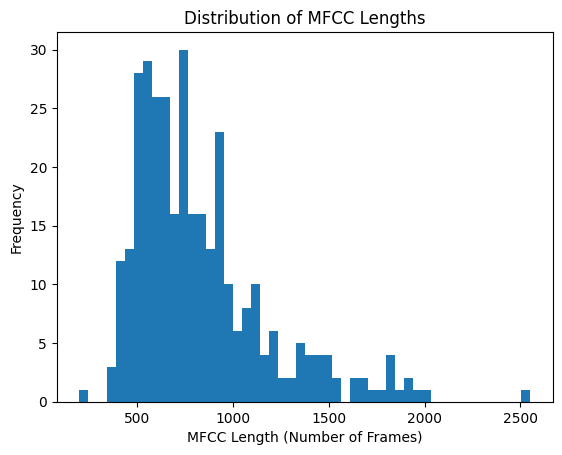

Max MFCC Length: 2553


In [14]:
# Ploting the mfcc length distributions
plt.hist(mfcc_lengths, bins=50)
plt.xlabel("MFCC Length (Number of Frames)")
plt.ylabel("Frequency")
plt.title("Distribution of MFCC Lengths")
plt.show()

# We need the max of these mfcc lengths for padding
max_length = np.max(mfcc_lengths)
print(f"Max MFCC Length: {max_length}")

In [15]:
# This script does padding with zeros on mfcc vectors for better processing
mfcc_data = {}
mfcc_equal_lengths = []

for emotion, mfcc_list in mfcc_no_padded_data.items():
    mfcc_data[emotion] = []

    for mfcc in mfcc_list:
        # Padding only in mfccs without maximum length
        if mfcc.shape[1] < max_length:
            pad_width = max_length - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_length]

        mfcc_data[emotion].append(mfcc)
        mfcc_equal_lengths.append(mfcc.shape[1])
# Saving the final mfcc vectors for later use
scipy.io.savemat(output_file, mfcc_data)
print(f"MFCC features saved to {output_file}")

MFCC features saved to /content/drive/MyDrive/Emotion_Recognition/mfcc_train.mat


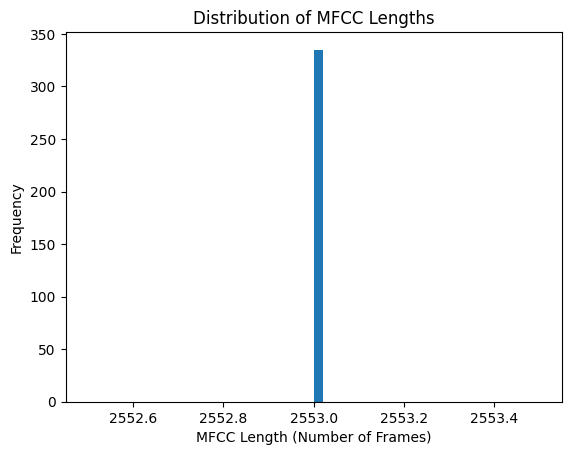

Min MFCC Length: 2553
Max MFCC Length: 2553


In [16]:
# Ploting the padded mfcc length distributions
plt.hist(mfcc_equal_lengths, bins=50)
plt.xlabel("MFCC Length (Number of Frames)")
plt.ylabel("Frequency")
plt.title("Distribution of MFCC Lengths")
plt.show()

# Min and max of mfccs
min_length = np.min(mfcc_equal_lengths)
max_length = np.max(mfcc_equal_lengths)
print(f"Min MFCC Length: {min_length}")
print(f"Max MFCC Length: {max_length}")